# Exploratory Data Analysis

Libraries

In [2]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import learning_curve
import joblib 
import seaborn as sns 
import warnings 
import matplotlib.pyplot as plt 

warnings.filterwarnings("ignore")

Load the Dataset

In [3]:
file_path = "hypertension_dataset.csv"
df = pd.read_csv(file_path)

Describe the dataset

In [ ]:
df.describe()

,Age,BMI,Cholesterol,Systolic_BP,Diastolic_BP,Alcohol_Intake,Stress_Level,Salt_Intake,Sleep_Duration,Heart_Rate,LDL,HDL,Triglycerides,Glucose
count,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000,174982.000000
mean,53.493319,27.494672,224.539335,134.505229,89.450315,14.991069,5.013041,8.482757,6.996468,74.495085,129.528271,64.573105,149.569836,134.488187
std,20.786353,7.213866,43.361589,26.019268,17.310789,8.652624,2.582341,3.750074,1.730731,14.438573,34.635795,20.190666,57.765006,37.526882
min,18.000000,15.000000,150.000000,90.000000,60.000000,0.000000,1.000000,2.000000,4.000000,50.000000,70.000000,30.000000,50.000000,70.000000
25%,36.000000,21.200000,187.000000,112.000000,74.000000,7.500000,3.000000,5.200000,5.500000,62.000000,100.000000,47.000000,100.000000,102.000000
50%,54.000000,27.500000,225.000000,135.000000,89.000000,15.000000,5.000000,8.500000,7.000000,74.000000,130.000000,65.000000,150.000000,134.000000
75%,71.000000,33.700000,262.000000,157.000000,104.000000,22.500000,7.000000,11.700000,8.500000,87.000000,160.000000,82.000000,200.000000,167.000000
max,89.000000,40.000000,299.000000,179.000000,119.000000,30.000000,9.000000,15.000000,10.000000,99.000000,189.000000,99.000000,249.000000,199.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174982 entries, 0 to 174981
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Country                  174982 non-null  object 
 1   Age                      174982 non-null  int64  
 2   BMI                      174982 non-null  float64
 3   Cholesterol              174982 non-null  int64  
 4   Systolic_BP              174982 non-null  int64  
 5   Diastolic_BP             174982 non-null  int64  
 6   Smoking_Status           174982 non-null  object 
 7   Alcohol_Intake           174982 non-null  float64
 8   Physical_Activity_Level  174982 non-null  object 
 9   Family_History           174982 non-null  object 
 10  Diabetes                 174982 non-null  object 
 11  Stress_Level             174982 non-null  int64  
 12  Salt_Intake              174982 non-null  float64
 13  Sleep_Duration           174982 non-null  float64
 14  Hear

Checking Data Types

In [ ]:
df.dtypes

Country                     object
Age                          int64
BMI                        float64
Cholesterol                  int64
Systolic_BP                  int64
Diastolic_BP                 int64
Smoking_Status              object
Alcohol_Intake             float64
Physical_Activity_Level     object
Family_History              object
Diabetes                    object
Stress_Level                 int64
Salt_Intake                float64
Sleep_Duration             float64
Heart_Rate                   int64
LDL                          int64
HDL                          int64
Triglycerides                int64
Glucose                      int64
Gender                      object
Education_Level             object
Employment_Status           object
Hypertension                object
dtype: object

Implementing One Hot Coding to Categorical Values

In [ ]:
# Define mapping for categorical columns
category_mappings = {
    'Smoking_Status': {'Never': 0, 'Current': 1},
    'Physical_Activity_Level': {'Low': 0, 'Moderate': 1, 'High': 2},
    'Family_History': {'No': 0, 'Yes': 1},
    'Gender': {'Female': 0, 'Male': 1},
    'Education_Level': {'Primary': 0, 'Secondary': 1, 'Tertiary': 2},
    'Employment_Status': {'Unemployed': 0, 'Employed': 1, 'Retired': 2},
    'Hypertension': {'Low': 0, 'High': 1}
}

# Apply the mappings
df_mapped = df.copy()

for column, mapping in category_mappings.items():
    if column in df_mapped.columns:
        df_mapped[column] = df_mapped[column].map(mapping)

# Display the mapped dataframe
df_mapped.head()


Checking Column Names

In [ ]:
df.columns

Index(['Country', 'Age', 'BMI', 'Cholesterol', 'Systolic_BP', 'Diastolic_BP',
       'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity_Level',
       'Family_History', 'Diabetes', 'Stress_Level', 'Salt_Intake',
       'Sleep_Duration', 'Heart_Rate', 'LDL', 'HDL', 'Triglycerides',
       'Glucose', 'Gender', 'Education_Level', 'Employment_Status',
       'Hypertension'],
      dtype='object')

Checking for Unique Values

In [ ]:
df.nunique()

Country                     20
Age                         72
BMI                        251
Cholesterol                150
Systolic_BP                 90
Diastolic_BP                60
Smoking_Status               3
Alcohol_Intake             301
Physical_Activity_Level      3
Family_History               2
Diabetes                     2
Stress_Level                 9
Salt_Intake                131
Sleep_Duration              61
Heart_Rate                  50
LDL                        120
HDL                         70
Triglycerides              200
Glucose                    130
Gender                       2
Education_Level              3
Employment_Status            3
Hypertension                 2
dtype: int64

Checking for Missing Values

In [ ]:
missing_values = df.isnull().sum()
missing_values

Country                    0
Age                        0
BMI                        0
Cholesterol                0
Systolic_BP                0
Diastolic_BP               0
Smoking_Status             0
Alcohol_Intake             0
Physical_Activity_Level    0
Family_History             0
Diabetes                   0
Stress_Level               0
Salt_Intake                0
Sleep_Duration             0
Heart_Rate                 0
LDL                        0
HDL                        0
Triglycerides              0
Glucose                    0
Gender                     0
Education_Level            0
Employment_Status          0
Hypertension               0
dtype: int64

Checking for Duplicate Values

In [17]:
duplicated_values = df.duplicated().sum()
duplicated_values

df = df.drop_duplicates()


Checking for Outliers

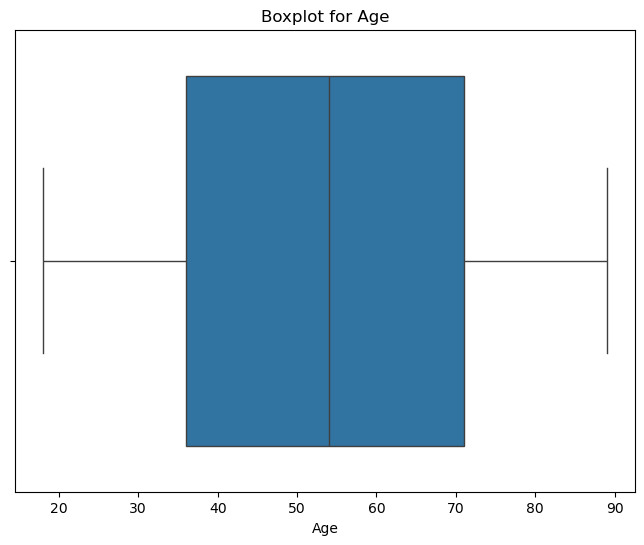

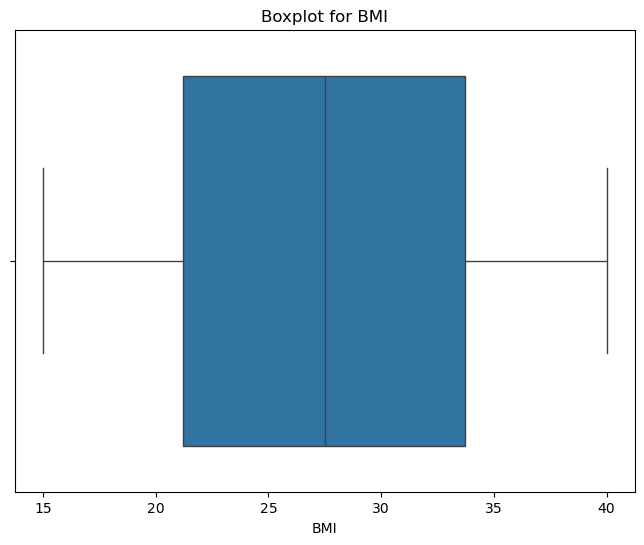

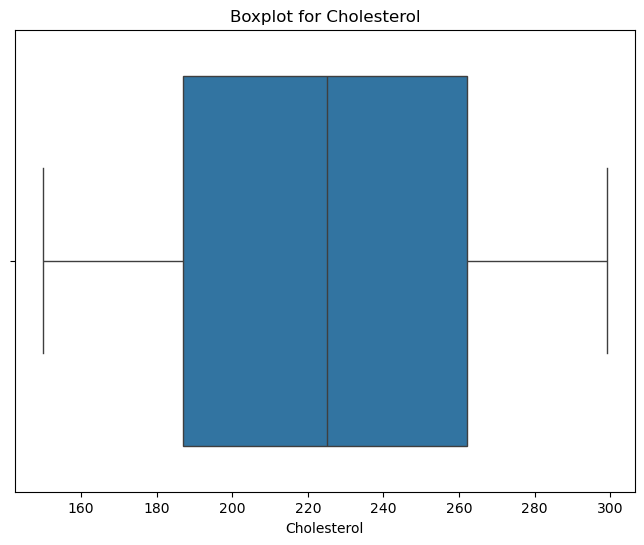

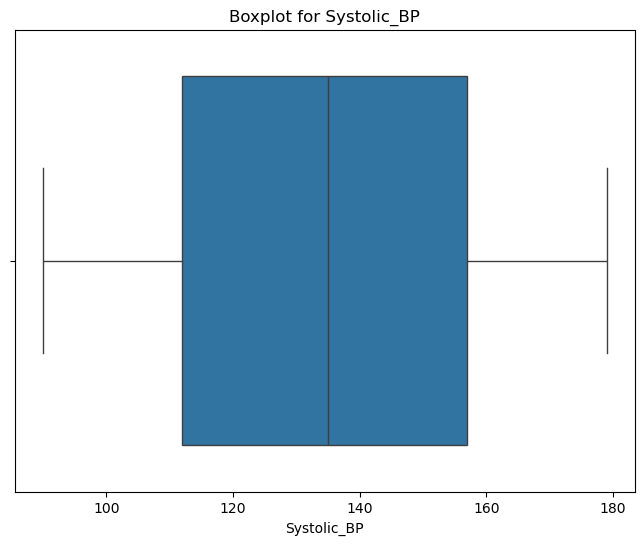

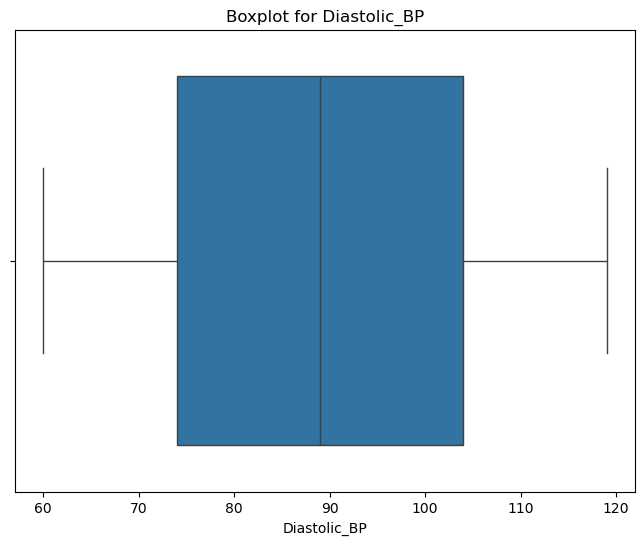

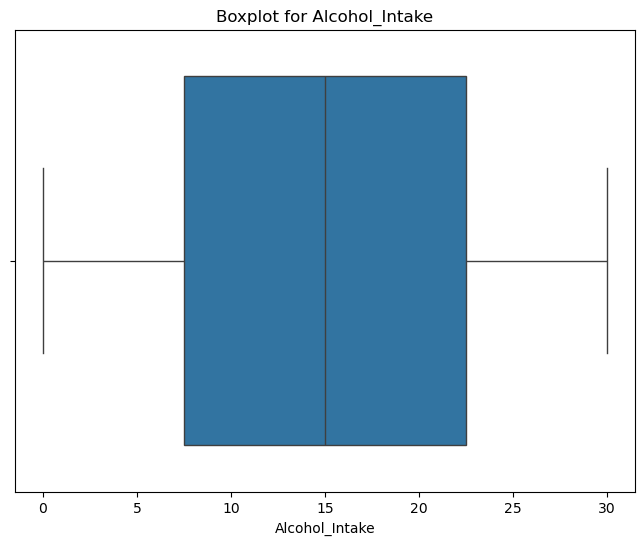

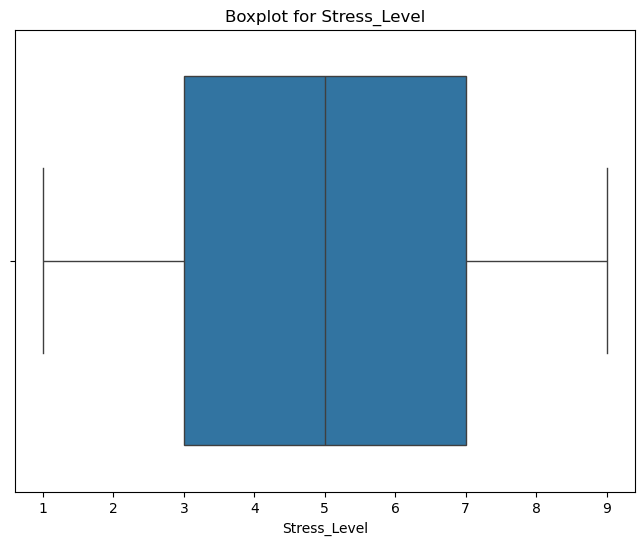

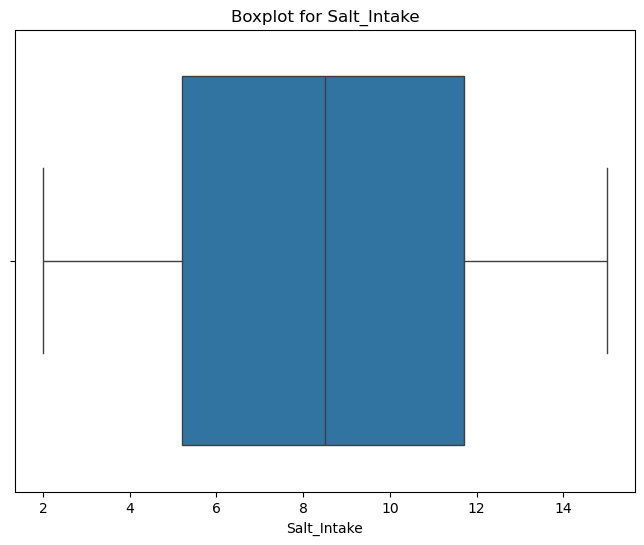

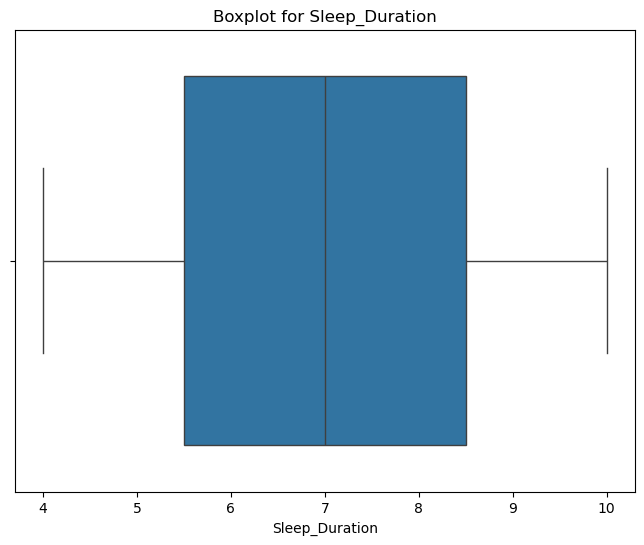

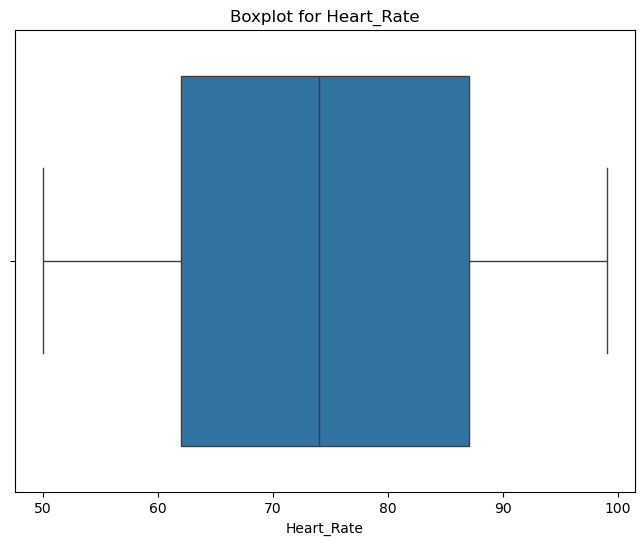

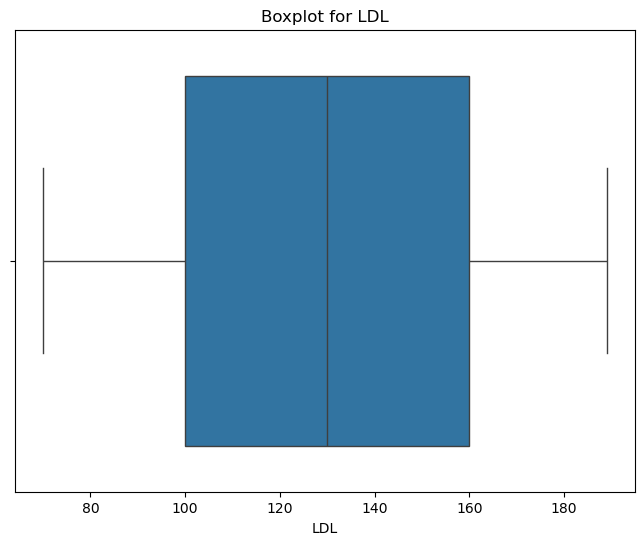

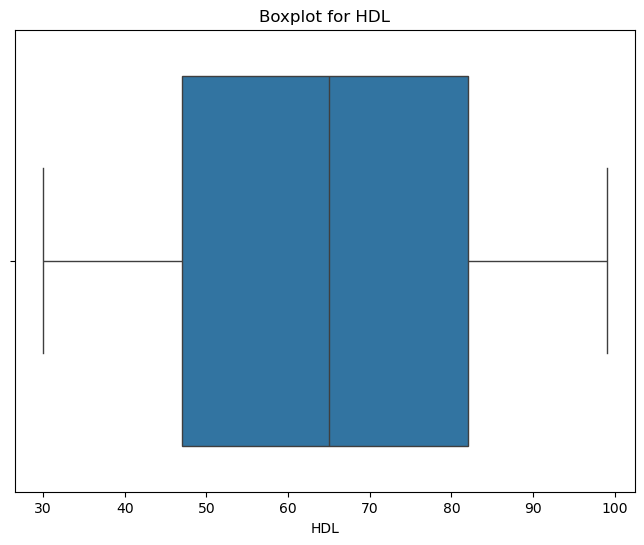

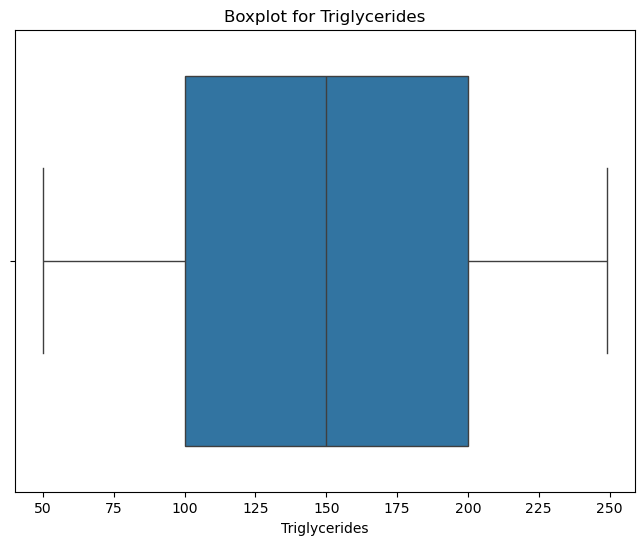

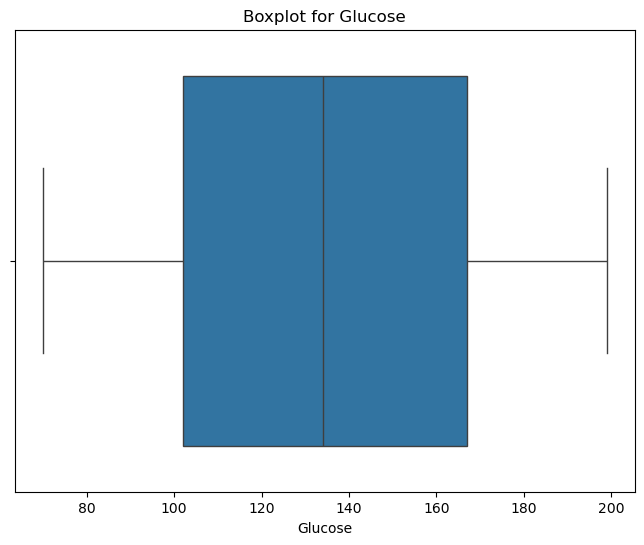

In [18]:
# Visualize outliers using boxplots
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

In [11]:
print("Proportion of Hypertension Values")
df['Hypertension'].value_counts(normalize=True)

Proportion of Hypertension Values


Hypertension
High    0.718823
Low     0.281177
Name: proportion, dtype: float64

Feature Scaling

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


Correlation Analysis

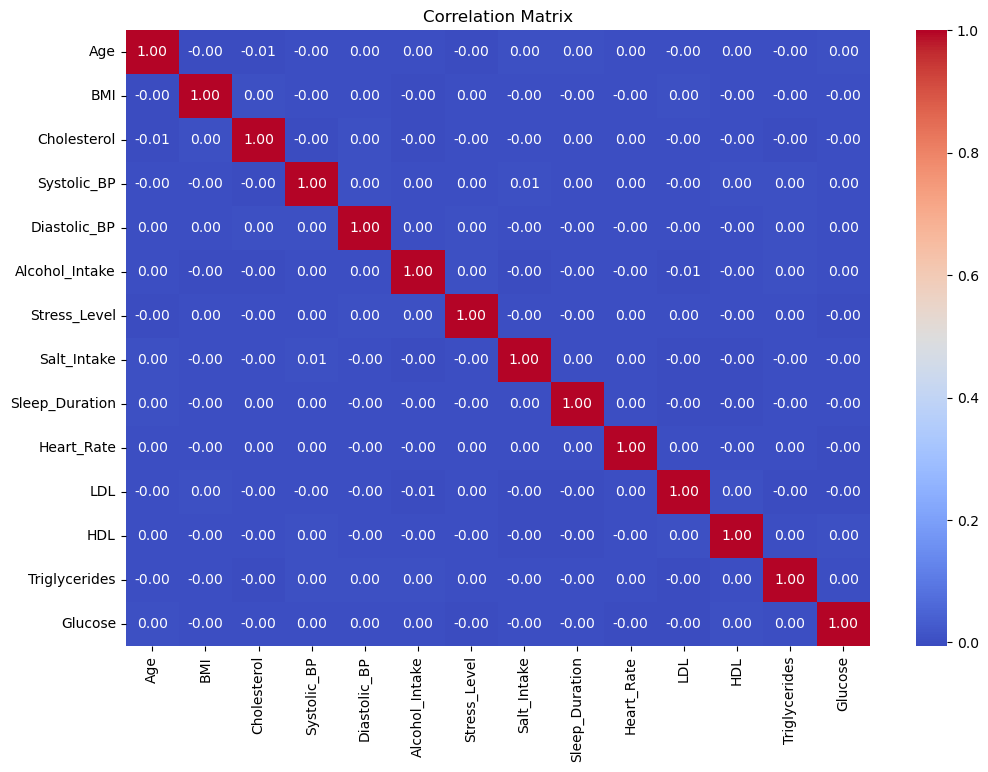

In [21]:
# Select only numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Training the Data
